In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Load the augmented data from the saved file
# data = np.load('/content/drive/My Drive/Capstone/Pickled/coral_augmented_combined_RCNN.npz')

# # Access the arrays from the loaded data
# X_train = data['X_train']
# y_train = data['y_train']
# X_test = data['X_test']
# y_test = data['y_test']

# # Check the shape of the loaded data
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

In [3]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_mask.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7488, 224, 224, 3)
y_train shape: (7488, 224, 224)
X_valid shape: (1880, 224, 224, 3)
y_valid shape: (1880, 224, 224)
X_test shape: (2344, 224, 224, 3)
y_test shape: (2344, 224, 224)


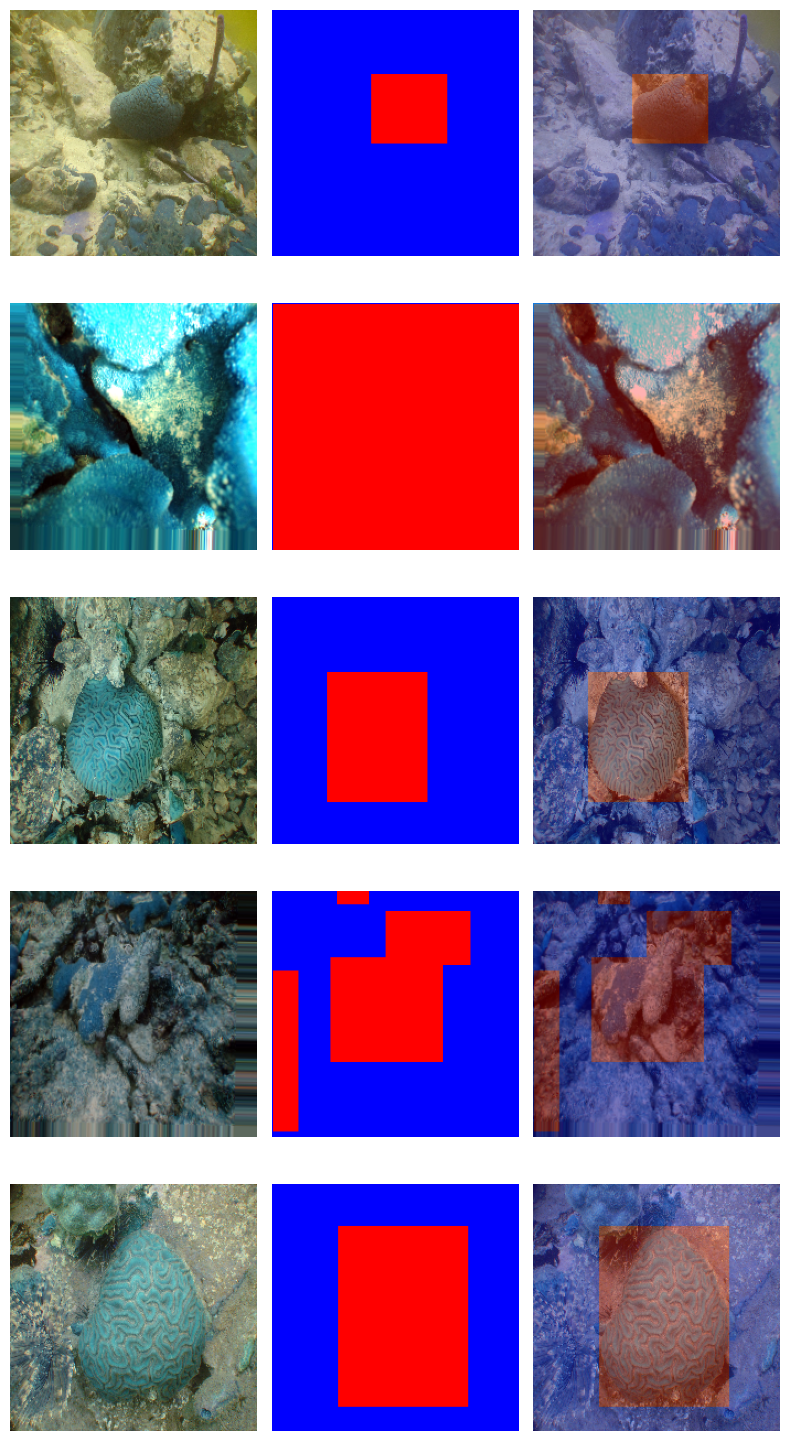

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Your data shapes
# Images shape: (899, 224, 224, 3)
# Masks shape: (899, 224, 224)

# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = X_train[i]
    mask = y_train[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(mask)
    blue_mask[mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(mask)
    red_mask[mask != 0] = 1

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask * 255  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    combined_mask = np.clip(combined_mask, 0, 255)

    # Overlay the combined mask on top of the original image
    overlay_image = image * 0.7 + combined_mask * 0.3

    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 255)

    # Plot the original image
    axes[i, 0].imshow(image.astype(np.uint8))
    axes[i, 0].axis('off')

    # Plot the modified mask with blue and red parts
    axes[i, 1].imshow(combined_mask.astype(np.uint8))
    axes[i, 1].axis('off')

    # Plot the overlay image
    axes[i, 2].imshow(overlay_image.astype(np.uint8))
    axes[i, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def simplified_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Bottleneck
    bottleneck = Conv2D(128, 3, activation='relu', padding='same')(pool1)

    # Expansive Path
    up1 = Concatenate()([UpSampling2D(size=(2, 2))(bottleneck), conv1])
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(up1)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv2)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the simplified U-Net model
model = simplified_unet()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 112, 112, 64  0          ['conv2d_22[0][0]']              
                                )                                                           

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
234/234 [==============================] - 1953s 8s/step - loss: 1.5925 - accuracy: 0.6753 - val_loss: 0.6616 - val_accuracy: 0.6834
Epoch 2/10
234/234 [==============================] - 1963s 8s/step - loss: 0.6503 - accuracy: 0.6769 - val_loss: 0.6383 - val_accuracy: 0.6834
Epoch 3/10
234/234 [==============================] - 1926s 8s/step - loss: 0.6388 - accuracy: 0.6769 - val_loss: 0.6319 - val_accuracy: 0.6834
Epoch 4/10
234/234 [==============================] - 1944s 8s/step - loss: 0.6359 - accuracy: 0.6768 - val_loss: 0.6275 - val_accuracy: 0.6834
Epoch 5/10
234/234 [==============================] - 1951s 8s/step - loss: 0.6305 - accuracy: 0.6769 - val_loss: 0.6255 - val_accuracy: 0.6834
Epoch 6/10
234/234 [==============================] - 1952s 8s/step - loss: 0.6296 - accuracy: 0.6769 - val_loss: 0.6248 - val_accuracy: 0.6834
Epoch 7/10
234/234 [==============================] - 1938s 8s/step - loss: 0.6293 - accuracy: 0.6769 - val_loss: 0.6245 - val_accuracy:

In [19]:
model.save('../models/coral_unet.h5')
# model.save('/content/drive/My Drive/Capstone/Pickled/coral_U-net.h5')

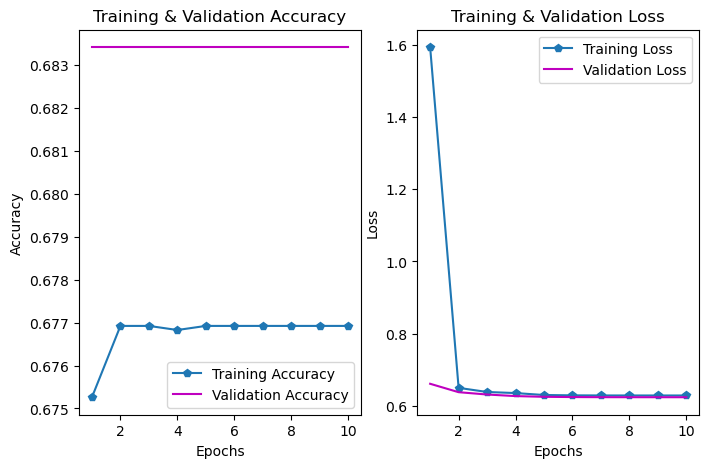

In [18]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [4]:
model = load_model('../models/coral_unet.h5')

2023-11-10 11:52:44.189694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Assuming you have a function for evaluating the model on your test data, you can use it here.
# For example:
evaluation_results = model.evaluate(X_test, y_test)

# You can print or use the evaluation results as needed.
print("Evaluation Results:", evaluation_results)


74/74 [==============================] - 175s 2s/step - loss: 0.6244 - accuracy: 0.6834
Evaluation Results: [0.6243797540664673, 0.6834076642990112]


In [5]:


# # Number of image-mask pairs to display
# num_pairs_to_display = 5

# # Create a figure with subplots
# fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# # Display the first 5 image-mask pairs
# for i in range(num_pairs_to_display):
#     image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     mask = masks[i]
#     label = labels[i]

#     # Create a blue mask for the back part
#     blue_mask = (mask == 0).astype(np.uint8) * 255

#     # Create a red mask for the white part
#     red_mask = (mask != 0).astype(np.uint8) * 255

#     # Create a new image with blue and red regions based on the masks
#     combined_mask = np.zeros_like(image)
#     combined_mask[:, :, 0] = red_mask  # Set the red channel to red_mask
#     combined_mask[:, :, 2] = blue_mask  # Set the blue channel to blue_mask

#     # Overlay the combined mask on top of the original image
#     overlay_image = cv2.addWeighted(image, 0.7, combined_mask, 0.3, 0)

#     # Predict the segmentation mask for the current image
#     predicted_mask = model.predict(np.expand_dims(images[i], axis=0))[0]

#     # Plot the original image
#     axes[i, 0].imshow(image)
#     axes[i, 0].axis('off')

#     # Plot the ground truth mask with blue and red parts
#     axes[i, 1].imshow(combined_mask)
#     axes[i, 1].axis('off')

#     # Plot the predicted segmentation mask
#     axes[i, 2].imshow(predicted_mask, cmap='gray')
#     axes[i, 2].set_title(f"Label: {label}")
#     axes[i, 2].axis('off')

# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plots
# plt.show()


74/74 [==============================] - 176s 2s/step


ValueError: could not broadcast input array from shape (224,224,1) into shape (224,224)

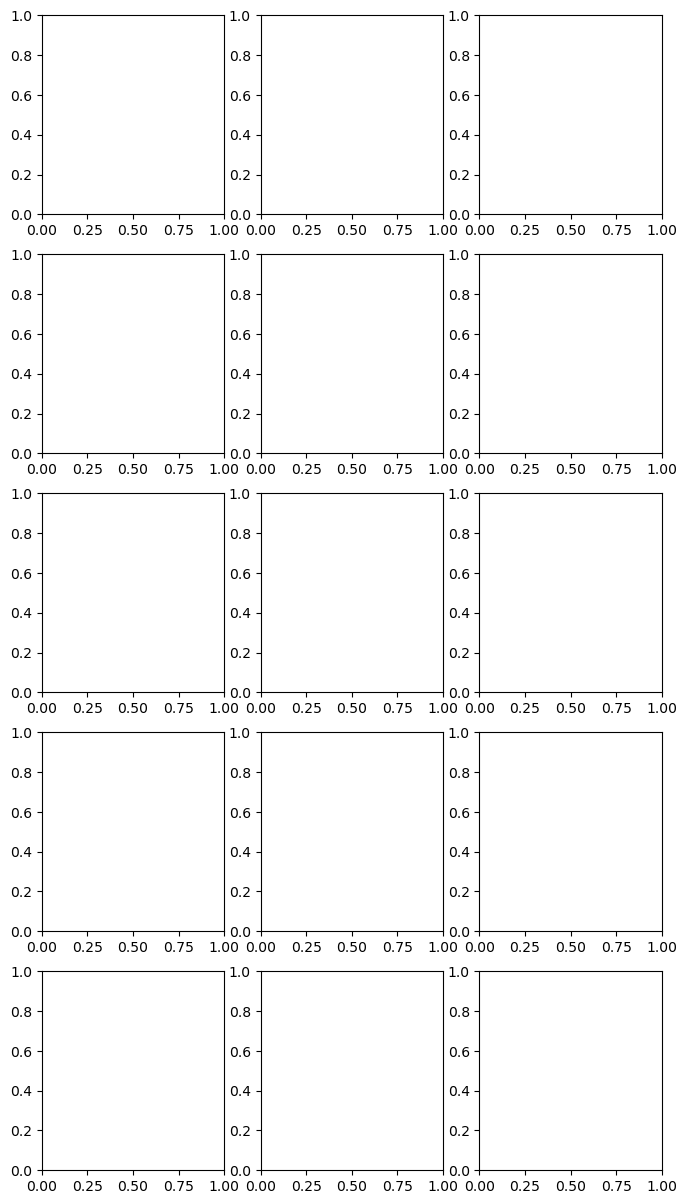

In [24]:
# Assuming y_pred contains predicted masks for X_test
predicted_masks = model.predict(X_test)


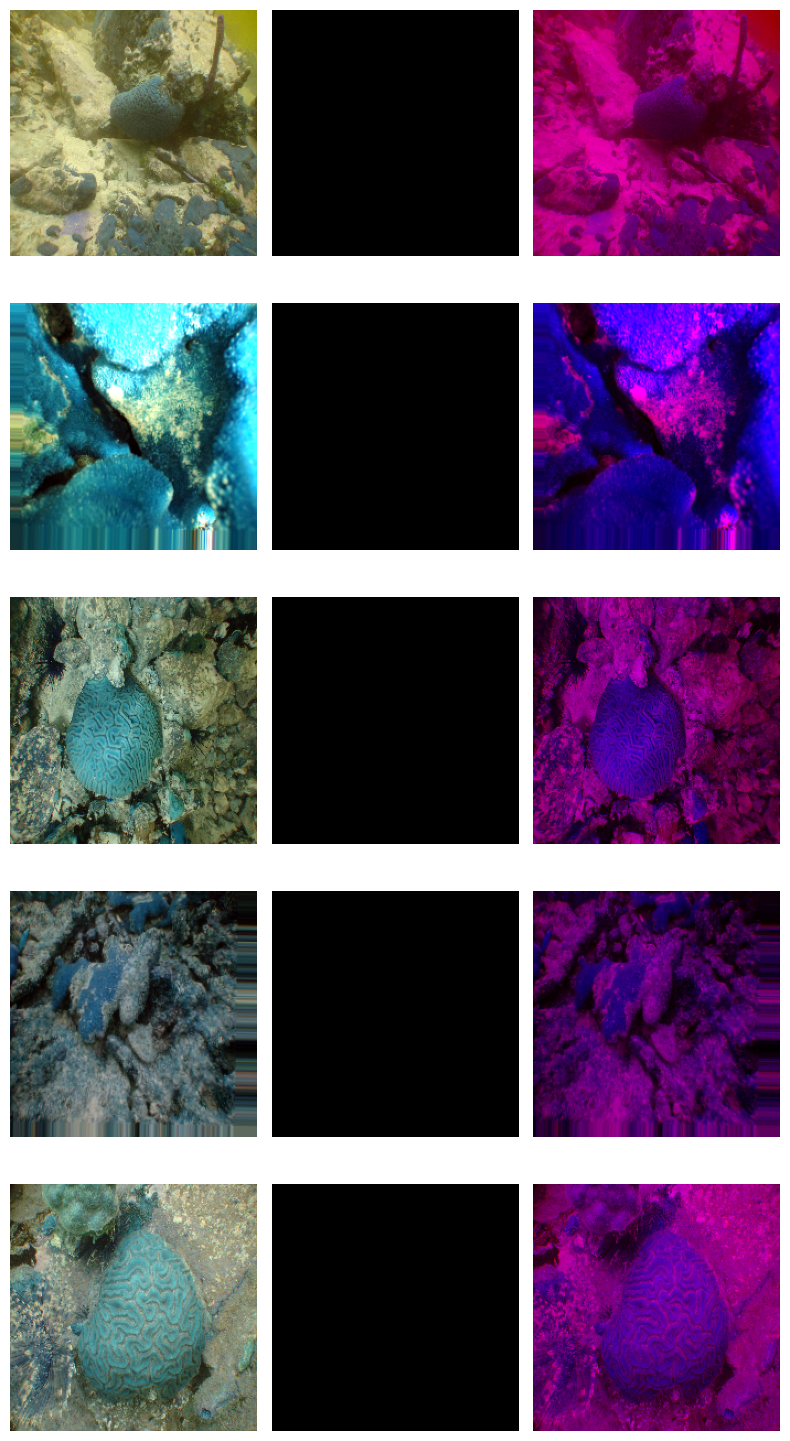

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train and predicted_masks are defined

# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = X_train[i]
    mask = predicted_masks[i]

    # Create a blue mask for the back part
    blue_mask = np.zeros_like(mask)
    blue_mask[mask == 0] = 1

    # Create a red mask for the white part
    red_mask = np.zeros_like(mask)
    red_mask[mask > 0.5] = 1  # Adjust the threshold based on your specific case

    # Remove the last dimension of red_mask and blue_mask
    red_mask = np.squeeze(red_mask)
    blue_mask = np.squeeze(blue_mask)

    # Create a new image with blue and red regions based on the masks
    combined_mask = np.zeros_like(image)
    combined_mask[:, :, 0] = red_mask * 255  # Set the red channel to red_mask
    combined_mask[:, :, 2] = blue_mask * 255  # Set the blue channel to blue_mask

    # Ensure the values are in the valid range
    combined_mask = np.clip(combined_mask, 0, 255)

    # Overlay the combined mask on top of the original image
    overlay_image = np.zeros_like(image)
    overlay_image[:, :, 0] = image[:, :, 0] * (1 - red_mask) + combined_mask[:, :, 0]  # Red channel
    overlay_image[:, :, 2] = image[:, :, 2] * (1 - blue_mask) + combined_mask[:, :, 2]  # Blue channel

    # Ensure the values are in the valid range
    overlay_image = np.clip(overlay_image, 0, 255)

    # Plot the original image
    axes[i, 0].imshow(image.astype(np.uint8), cmap='gray')
    axes[i, 0].axis('off')

    # Plot the modified mask with blue and red parts
    axes[i, 1].imshow(combined_mask.astype(np.uint8))
    axes[i, 1].axis('off')

    # Plot the overlay image
    axes[i, 2].imshow(overlay_image.astype(np.uint8))
    axes[i, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [34]:
print(np.unique(predicted_masks[i]))


[2.1001101e-04 3.2348552e-01]


74/74 [==============================] - 186s 3s/step


IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 1

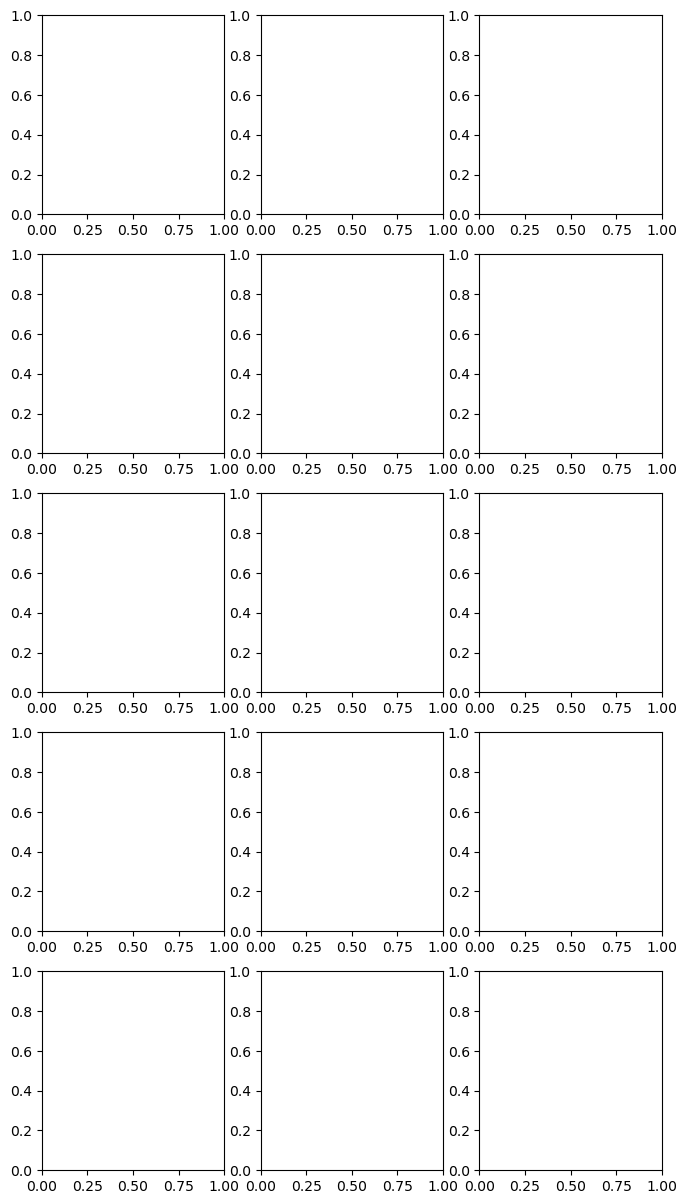

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred contains predicted masks for X_test
predicted_masks = model.predict(X_test)

# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = X_test[i]
    mask = predicted_masks[i]

    # Convert to RGB if not already in that format
    if image.shape[-1] == 1:
        image = np.concatenate([image] * 3, axis=-1)

    # Create a new image with only the masked region
    masked_region = image.copy()
    masked_region[mask == 0] = 0

    # Plot the original image
    axes[i, 0].imshow(image.astype(np.uint8))
    axes[i, 0].axis('off')

    # Plot the mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')

    # Plot the masked region
    axes[i, 2].imshow(masked_region.astype(np.uint8))
    axes[i, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
